In [7]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [8]:
def generate_random_scara_dataset(num_samples=1000, vary_theta4=True):
    a1, a2, d4 = 250, 150, 150  # mm

    def dh_matrix(theta, d, a, alpha):
        ct, st = np.cos(theta), np.sin(theta)
        ca, sa = np.cos(alpha), np.sin(alpha)
        return np.array([
            [ct, -st * ca,  st * sa, a * ct],
            [st,  ct * ca, -ct * sa, a * st],
            [0,   sa,       ca,      d],
            [0,   0,        0,       1]
        ])

    theta1 = np.random.uniform(np.deg2rad(-120), np.deg2rad(120), num_samples)
    theta2 = np.random.uniform(np.deg2rad(-130), np.deg2rad(130), num_samples)
    d3 = np.random.uniform(0, 300, num_samples)
    theta4 = np.random.uniform(np.deg2rad(-180), np.deg2rad(180), num_samples) if vary_theta4 else np.zeros(num_samples)

    P_x, P_y, P_z, theta4_actual = [], [], [], []
    R_feats = []

    for i in range(num_samples):
        th1, th2, d, th4 = theta1[i], theta2[i], d3[i], theta4[i]

        A1 = dh_matrix(th1, 0, a1, 0)
        A2 = dh_matrix(th2, 0, a2, np.pi)
        A3 = dh_matrix(0, d, 0, 0)
        A4 = dh_matrix(th4, d4, 0, 0)

        T = A1 @ A2 @ A3 @ A4
        P = T[:3, 3]
        R = T[:3, :3].flatten()  # 9 values

        # Compute actual theta4 from relative rotation
        R_0_2 = (A1 @ A2)[:3, :3]
        R_2_4 = R_0_2.T @ T[:3, :3]
        n_x, n_y = R_2_4[0, 0], R_2_4[1, 0]
        s12, c12 = np.sin(th1 + th2), np.cos(th1 + th2)
        theta4_calc = np.arctan2(s12 * n_x + c12 * n_y, c12 * n_x - s12 * n_y)

        P_x.append(P[0])
        P_y.append(P[1])
        P_z.append(P[2])
        theta4_actual.append(theta4_calc)
        R_feats.append(R.tolist())

    # Create DataFrame
    df = pd.DataFrame({
        'P_x': P_x,
        'P_y': P_y,
        'P_z': P_z,
        'theta1': np.rad2deg(theta1),
        'theta2': np.rad2deg(theta2),
        'd3': d3,
        'theta4': np.rad2deg(theta4_actual),
    })

    R_cols = [f'R{i}' for i in range(9)]
    for i, col in enumerate(R_cols):
        df[col] = [r[i] for r in R_feats]

    return df

# Save the dataset
dataset = generate_random_scara_dataset(1000, vary_theta4=True)
dataset.to_csv("scara_dataset.csv", index=False)


In [9]:
data = pd.read_csv("scara_dataset.csv")
input_cols = pd.concat([data.iloc[:, :3], data.iloc[:, 7:]], axis=1)
output_cols = data.drop(columns = input_cols.columns)
labels = output_cols.columns

X = input_cols.values
y = output_cols.values

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# === Split dataset ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=100, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=100, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim=12, hidden_dim=128, output_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [12]:
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)


In [13]:
# === Tracking ===
train_losses_per_joint = [[] for _ in range(4)]
val_losses_per_joint   = [[] for _ in range(4)]
test_losses_per_joint  = [[] for _ in range(4)]

best_val_mse_per_joint = [float('inf')] * 4
best_val_epoch_per_joint = [-1] * 4

best_model_state = None
best_val_loss = float('inf')
patience = 0
early_stop_patience = 1000

# === Training loop ===
for epoch in range(10000):
    model.train()
    pred = model(X_train)
    losses = [criterion(pred[:, i], y_train[:, i]) for i in range(4)]
    total_loss = sum(losses)

    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    for i in range(4):
        train_losses_per_joint[i].append(losses[i].item())

    # === Validation ===
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        test_pred = model(X_test)
        val_total = 0
        for i in range(4):
            v = criterion(val_pred[:, i], y_val[:, i]).item()
            t = criterion(test_pred[:, i], y_test[:, i]).item()
            val_losses_per_joint[i].append(v)
            test_losses_per_joint[i].append(t)
            val_total += v

            if v < best_val_mse_per_joint[i]:
                best_val_mse_per_joint[i] = v
                best_val_epoch_per_joint[i] = epoch + 1

    if val_total < best_val_loss:
        best_val_loss = val_total
        best_model_state = model.state_dict()
        patience = 0
    else:
        patience += 1

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}: Total Val Loss = {val_total:.6f}")

    if patience >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# === Restore best model ===
model.load_state_dict(best_model_state)
model.eval()

# === Inference ===
with torch.no_grad():
    y_pred = model(X_test).numpy()

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test.numpy())

# === Test Metrics ===
print("\nTest Metrics:")
for i, name in enumerate(labels):
    mae = mean_absolute_error(y_test_orig[:, i], y_pred_orig[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_orig[:, i], y_pred_orig[:, i]))
    print(f"{name}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

# === Best Epochs Table ===
print("\nBest Validation Results:")
for i, name in enumerate(labels):
    print(f"{name}: Best Epoch = {best_val_epoch_per_joint[i]}, MSE = {best_val_mse_per_joint[i]:.6f}")

Epoch 1000: Total Val Loss = 0.171157
Epoch 2000: Total Val Loss = 0.084462
Epoch 3000: Total Val Loss = 0.060078
Epoch 4000: Total Val Loss = 0.052975
Epoch 5000: Total Val Loss = 0.048524
Epoch 6000: Total Val Loss = 0.045775
Epoch 7000: Total Val Loss = 0.043239
Epoch 8000: Total Val Loss = 0.041820
Epoch 9000: Total Val Loss = 0.042246
Epoch 10000: Total Val Loss = 0.041009

Test Metrics:
theta1: MAE = 1.11, RMSE = 1.56
theta2: MAE = 3.23, RMSE = 5.45
d3: MAE = 1.83, RMSE = 2.40
theta4: MAE = 10.61, RMSE = 26.99

Best Validation Results:
theta1: Best Epoch = 9884, MSE = 0.000473
theta2: Best Epoch = 9915, MSE = 0.006042
d3: Best Epoch = 9999, MSE = 0.000546
theta4: Best Epoch = 9432, MSE = 0.032913


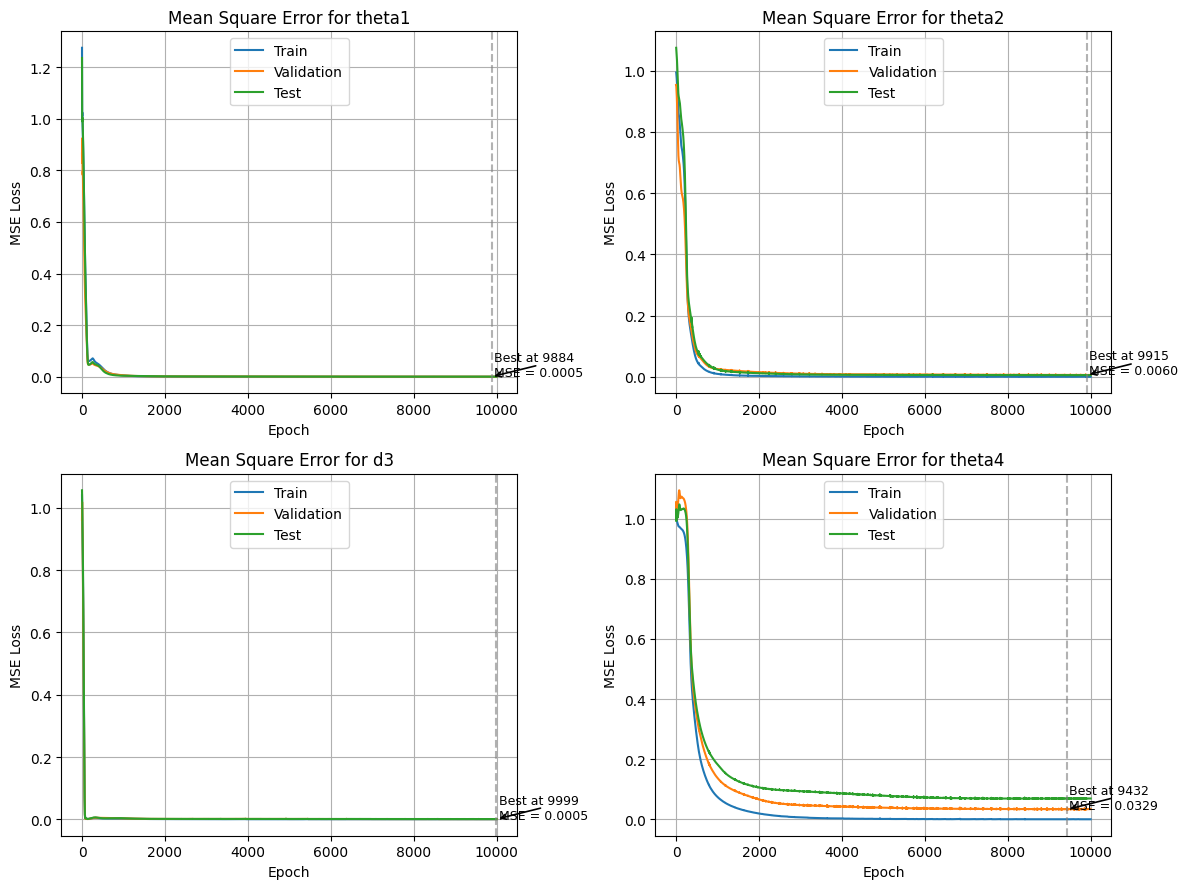

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
axs = axs.flatten()

for i in range(4):
    axs[i].plot(train_losses_per_joint[i], label='Train')
    axs[i].plot(val_losses_per_joint[i], label='Validation')
    axs[i].plot(test_losses_per_joint[i], label='Test')
    axs[i].axvline(best_val_epoch_per_joint[i], color='gray', linestyle='--', alpha=0.6)
    axs[i].annotate(f"Best at {best_val_epoch_per_joint[i]}\nMSE = {best_val_mse_per_joint[i]:.4f}",
                    xy=(best_val_epoch_per_joint[i], best_val_mse_per_joint[i]),
                    xytext=(best_val_epoch_per_joint[i]+50, best_val_mse_per_joint[i]+0.002),
                    arrowprops=dict(arrowstyle='->', lw=1.2), fontsize=9)

    axs[i].set_title(f"Mean Square Error for {labels[i]}")
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("MSE Loss")
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.savefig("figures/loss_plot.png")
plt.show()


Correlation Coefficient (R):
theta1: R = 0.99975
theta2: R = 0.99751
d3: R = 0.99964
theta4: R = 0.96477


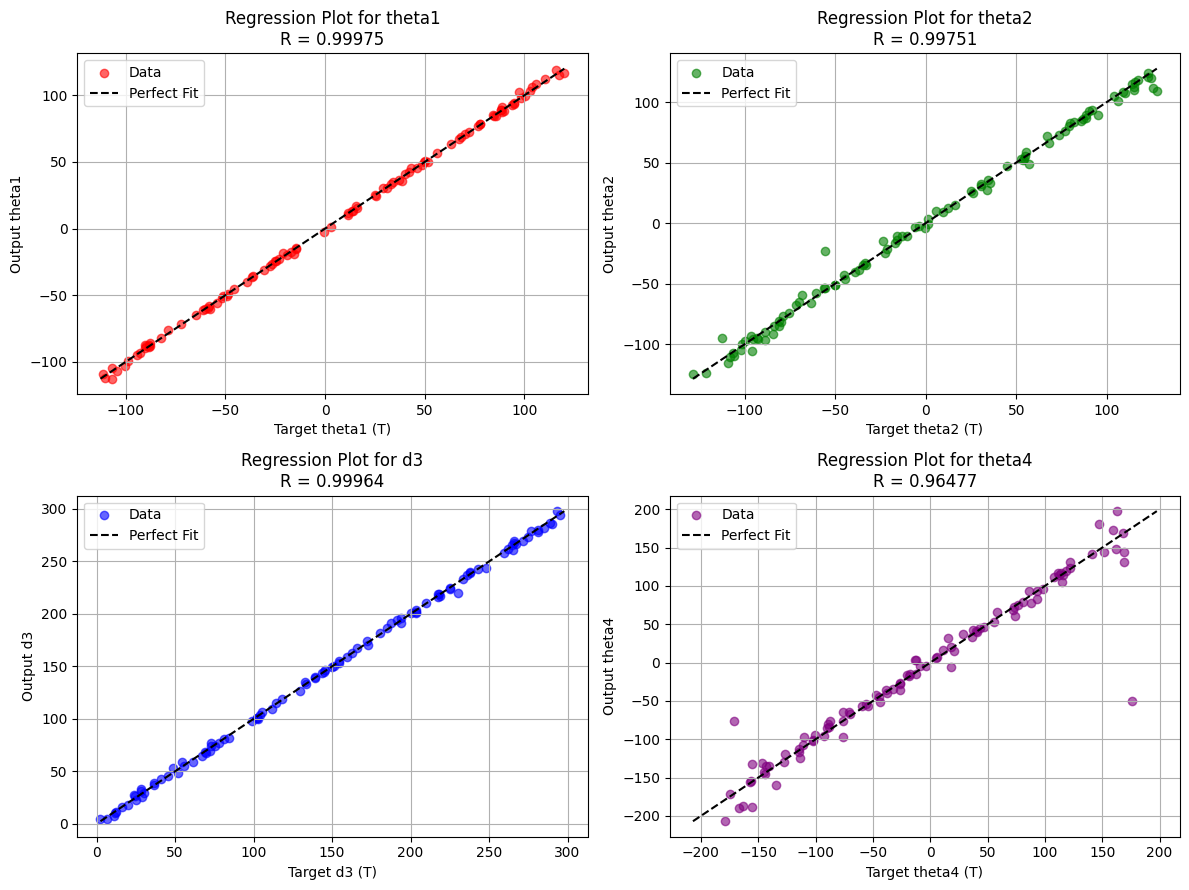

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
colors = ['red', 'green', 'blue', 'purple']
R_values = []

print("\nCorrelation Coefficient (R):")
for i, ax in enumerate(axs.flat):
    # Calculate correlation coefficient (R)
    R = np.corrcoef(y_test_orig[:, i], y_pred_orig[:, i])[0, 1]
    R_values.append(R)
    print(f"{labels[i]}: R = {R:.5f}")

    # Plot scatter and perfect fit line
    ax.scatter(y_test_orig[:, i], y_pred_orig[:, i], color=colors[i], label='Data', alpha=0.6)
    min_val = min(y_test_orig[:, i].min(), y_pred_orig[:, i].min())
    max_val = max(y_test_orig[:, i].max(), y_pred_orig[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Fit')

    ax.set_title(f'Regression Plot for {labels[i]}\nR = {R:.5f}')
    ax.set_xlabel(f'Target {labels[i]} (T)')
    ax.set_ylabel(f'Output {labels[i]}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig("figures/regressions.png")
plt.show()